# Problem Set 1 - K-Nearest Neighbor and NaiveBayes classifiers
## CSCI 5622 - Spring 2022


Student name: Aditya Srivastava

Only submit this notebook to canvas (no zip files).

For today's assignment, we will be implementing our own K-Nearest Neighbors classifier (KNNClassifier) algorithm and a Naive Bayes classifier. 

*But Professor Quigley, hasn't someone else already written KNN before?*

Yes, you are not the first to implement KNN, or basically any algorithm we'll work with in this class. But
1. I'll know that you know what's really going on
2. You'll know you can do it, because
    1. someday you might have to implement some machine learning algorithm from scratch - maybe for a new platform (do you need to run python on your SmartToaster just to get it to
learn how users like their toast?), maybe because you want to tweak the algorithm (there's always a better approach...),
    2. maybe because you're working on something important, and you need to control exactly what's on there
(should you really be running anaconda on your secret spy plane?).

That said - we're not going to implement *everything*. We'll start by importing a few helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors
import data
import tests
%matplotlib inline

*Wait a minute - didn't we just import Scikit-learn (sklearn)? The package with baked-in machine learning tools?*
 Yes - but it also has a ton of helper functions that we'll be using later.

You will be guided through the different questions and you'll be expected to complete the classes and the functions following the provided signatures.
 Sometimes at the end of a question we would provide a difficulty estimate using
the average scored by students who attempted the question (or a similar one) in previous assignments.

Remember to avoid adding positional arguments and make sure the returned values have the correct format (this applies to all assignments).
The alternative is that your solution might be rejected by the auto-grader (we won't be debugging your code).
We will provide some basic sanity checks. They're in no means exhaustive and passing them does not imply
your solution is 100% correct.


For example, you're required to complete the method `compute_something` of class A.
We provide examples of acceptable solutions.

In [2]:
# This cell can be removed from the submitted notebook
class A:
    def compute_something(self, X):
        """
        :return: numpy array of zeros, with shape (4,)
        """
        # BEGIN
        answer = None
        # END
        return answer


class A1:  # Acceptable solution:
    # - the added y is an optional argument and omitting it does not affect the solution
    # - the returned object has the expected structure.
    def compute_something(self, X, y=None):
        # BEGIN
        return np.zeros((4,))
        # END


class A2:  # Wrong format:
    # - your solution requires a new positional argument y!
    # - the returned object does not have the expected format!
    # - solution outside the delimiters # BEGIN # END
    def compute_something(self, X, y):
        return [0, 0, 0, 0]


class A3:  # Acceptable solution:
    # You're free to add your own helper functions/methods
    def compute_something(self, X):
        # BEGIN
        return self.get_zeros(4)
        # END

    def get_zeros(self, i):
        return np.zeros((i,))


First, let's also load a dataset to play with and start working to build out our own classifier.

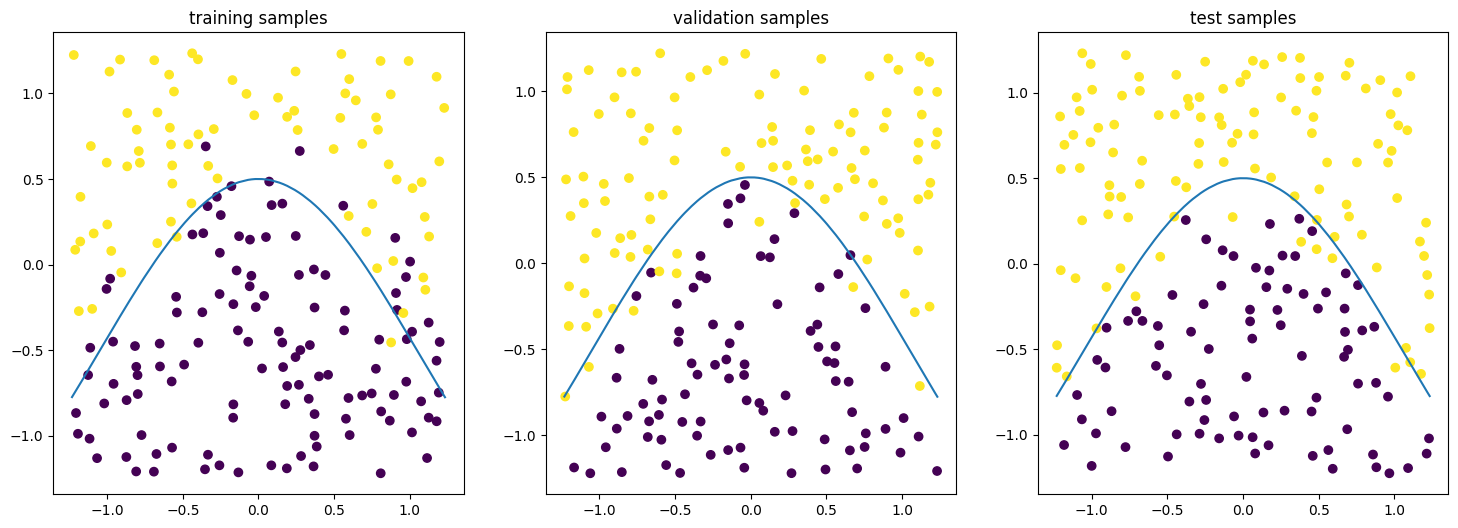

In [3]:
binary_data = data.BinaryData()
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
for i, name in enumerate(["training", "validation", "test"]):
    axs[i].plot(*binary_data.boundary())
    axs[i].set_title("%s samples" % name)
axs[0].scatter(binary_data.X_train[:, 0], binary_data.X_train[:, 1], c=binary_data.y_train)
axs[1].scatter(binary_data.X_valid[:, 0], binary_data.X_valid[:, 1], c=binary_data.y_valid)
axs[2].scatter(binary_data.X_test[:, 0], binary_data.X_test[:, 1], c=binary_data.y_test)
plt.show()

We have data! The `binary_data` instance has the following attributes:
   - a training set (`X_train, y_train`): to train the model and on which the prediction is based
   - a validation set (`X_valid, y_valid`): to select the best __hyper-parameters__ of the model
   - a test set (`X_test, y_test`): to evaluate the performance of the model on unseen data

### Problem 1: Complete our KNN Classifier - 30 Points

The KNNClassifier class we're implementing will have similar design to the K-Nearest Neighbors classifier class from *scikit-learn*:
- Initialize the classifier with corresponding parameters (number of neighbors k)
- A `fit` method that uses the training data
- A `predict` method that returns the predicted labels given data `X`

We've written out a lot of the structure for you for consistency across different parts of the assignment and so
you can focus on the "important" stuff that actually relates to the machine learning itself.

In [4]:
class KNNClassifier:
    
    def __init__(self, k=5):
        """
        Initialize our custom KNN classifier
        :param k: the number of nearest neighbors to consider for classification
        """
        self._k = k
        self._ball_tree = None
        self._y = None
        self.label_to_index = None
        self.index_to_label = None
        self.population_most_common = None

    def fit(self, X, y):
        """
        Fit the model using the provided data
        :param X: 2-D np.array of shape (number training samples, number of features)
        :param y: 1-D np.array of shape (number training samples,)
        :return: self
        """
        self._ball_tree = sklearn.neighbors.BallTree(X)  # See documentation of BallTree and how it's used
        self._y = y
        # Should be used to map the classes to {0,1,..C-1} if needed (C is the number of classes)
        # We can assume that the training data contains samples from all the possible classes
        classes = np.unique(y)
        self.label_to_index = dict(zip(classes, range(classes.shape[0])))
        self.index_to_label = dict(zip(range(classes.shape[0]), classes))

        label_values, label_counts = np.unique(y, return_counts=True)
        self.training_most_common = label_values[np.argmax(label_counts)]

        return self

    def majority_vote(self, indices_nearest_k, distances_nearest_k=None):
        """
        Given indices of the nearest k neighbors for each point, report the majority label of those points.
        :param indices_nearest_k: np.array containing the indices of training neighbors, of shape (M, k)
        :param distances_nearest_k: np.array containing the corresponding distances of training neighbors, of shape (M, k)
        :return: The majority label for each row of indices, shape (M,)
        """

        # Workspace 1.1
        #BEGIN 
        # DONE: Determine majority for each row of indices_nearest_k
        # DONE: if there is a tie, set the label to the most common label in the training set
        # code here
        if self.population_most_common == None:
            most_common_label = None
            most_common_label_count = float('-inf')
            c = {}
            for l in self._y:
                if l not in c:
                    c[l] = 0
                c[l] += 1
                if c[l] > most_common_label_count:
                    most_common_label = l
                    most_common_label_count = c[l]
            self.population_most_common = most_common_label

        voted_labels = np.empty(indices_nearest_k.shape[0]) # You can replace this
        for i, row in enumerate(indices_nearest_k):

            # makes classifer consistent across all k
            zero_dist = False
            for j, d in enumerate(distances_nearest_k[i]):
                if d == 0:
                    voted_labels[i] = self._y[row[j]]
                    zero_dist = True
                    break

            if zero_dist:
                continue
            
            # regular majority voting
            labels = [self._y[j] for j in row]
            c_d = {}
            for l in labels:
                if l not in c_d:
                    c_d[l] = 0
                c_d[l] += 1
            
            first_most_common_label = None
            first_most_common_label_count = float('-inf')
            second_most_common_label = None
            second_most_common_label_count = float('-inf')
            for l in c_d:
                if c_d[l] > first_most_common_label_count:
                    second_most_common_label = first_most_common_label
                    second_most_common_label_count = first_most_common_label_count
                    first_most_common_label = l
                    first_most_common_label_count = c_d[l]
                elif c_d[l] > second_most_common_label_count:
                    second_most_common_label = l
                    second_most_common_label_count = c_d[l]

            if len(c_d) == 1:
                voted_labels[i] = first_most_common_label
            else:
                if first_most_common_label_count == second_most_common_label_count:
                    voted_labels[i] = self.population_most_common
                else:
                    voted_labels[i] = first_most_common_label
        # #END
        return voted_labels

    def predict(self, X):
        """
        Given new data points, classify them according to the training data provided in fit and number of neighbors k
        You should use BallTree to get the distances and indices of the nearest k neighbors
        :param X: feature vectors (num_points, num_features)
        :return: 1-D np.array of predicted classes of shape (num_points,)
        """
        # Workspace 1.2
        #BEGIN 
        # code here
        distances_nearest_k, indices_nearest_k = self._ball_tree.query(X, k=self._k)                    
        #END
        return self.majority_vote(indices_nearest_k, distances_nearest_k)

    def confusion_matrix(self, X, y):
        """
        Generate the confusion matrix for the given data
        :param X: an np.array of feature vectors of points, shape (N, n_features)
        :param y: the corresponding correct classes of our set, shape (N,)
        :return: a C*C np.array of counts, where C is the number of classes in our training data
        """
        # Workspace 1.3
        # The rows of the confusion matrix correspond to the counts from the true labels, the columns to the predictions'
        # DONE: Run classification for the test set X, compare to test answers y, and add counts to matrix
        #BEGIN 
        # assume that the fit function has already been run
        preds = self.predict(X)

        c_matrix = np.zeros((len(self.label_to_index), len(self.label_to_index)))
        for r, c in zip([self.label_to_index[l] for l in y], [self.label_to_index[l] for l in preds]):
            c_matrix[r][c] += 1
        #END
        return c_matrix

    def accuracy(self, X, y):
        """
        Return the accuracy of the classifier on the data (X_test, y_test)
        :param X: np.array of shape (m, number_features)
        :param y: np.array of shape (m,)
        :return: accuracy score [float in (0,1)]
        """
        # Workspace 1.4
        # DONE: Compute accuracy on X
        #BEGIN 
        c_matrix = self.confusion_matrix(X, y)
        correct = 0
        for i in self.index_to_label:
            correct += c_matrix[i][i]
        score = correct/len(y)
        #END
        return score

In [5]:
# Test cell, uncomment to run the tests
tests.testKNN(KNNClassifier)

Question 1.1: [PASS]
Question 1.2: [PASS]
Question 1.3: [PASS]
Question 1.4: [PASS]


*But professor, this code isn't complete!*

1.1 [5 points] Complete the `majority_vote` function to determine the majority class of a series of neighbors.
If there is a tie, then you should remove the farthest element until the tie is broken. (Avg __4.6__)

1.2 [5 points] Complete the `predict` function to capture the predicted class of a new datapoint (Avg __4.9__)

 - HINT: Use the BallTree documentation to determine how to retrieve neighbors from the model (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)

1.3 [5 points] Complete the `confusion_matrix` function to reveal the results of classification (Avg __5__)

1.4 [5 points] Complete the `accuracy` function to get accuracy of the classifier based on a given test data (Avg __5__)

Below, we'll be using our KNNClassifier (sent in as "model") to show how we would predict any points in space given the input data.

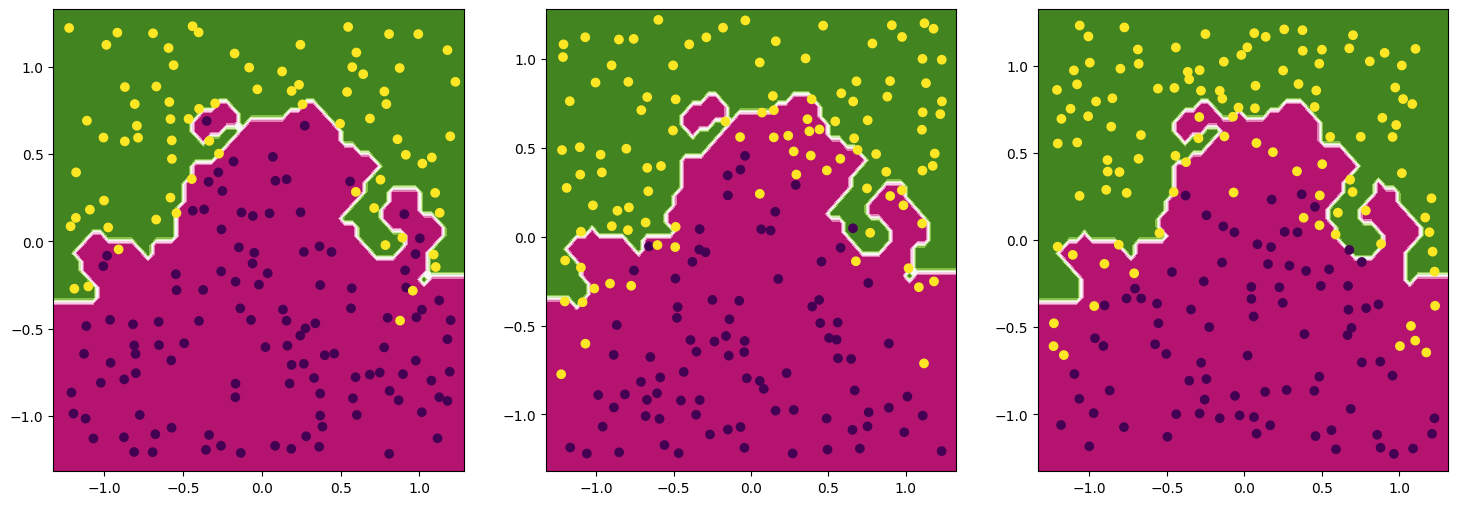

In [6]:
# This cell is to show the decision surface of the classifier
# You can change k to visualize KNN behavior
knn = KNNClassifier(2).fit(binary_data.X_train, binary_data.y_train)
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
tests.show_decision_surface(knn, binary_data.X_train, binary_data.y_train, axs[0])
tests.show_decision_surface(knn, binary_data.X_valid, binary_data.y_valid, axs[1])
tests.show_decision_surface(knn, binary_data.X_test, binary_data.y_test, axs[2])
plt.show()

1.5 [5 points] For each k in the range [1,32], fit a KNNClassifier on the training set and plot the accuracies on training and validation
data versus k. What's the value of k that yields the best accuracy on the training set? on the validation set? Which one
 should we choose? (Avg __4.8__)

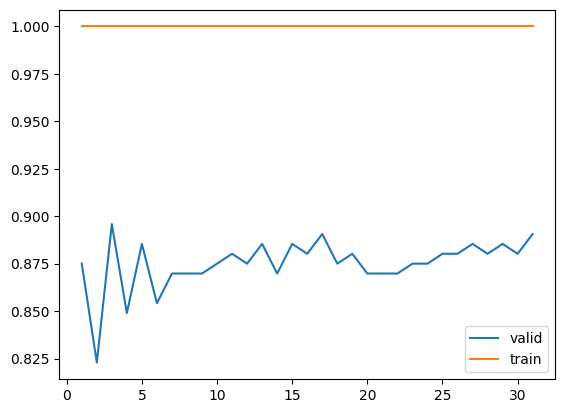

In [7]:
# Workspace 1.5.a
#DONE: Try different Ks
ks = list(range(1, 32))
accuracies_train = []
accuracies_valid = []
for k in ks:
    #BEGIN 
    knn = KNNClassifier(k).fit(binary_data.X_train, binary_data.y_train)
    accuracies_train.append(knn.accuracy(binary_data.X_train, binary_data.y_train))
    accuracies_valid.append(knn.accuracy(binary_data.X_valid, binary_data.y_valid))
    #END
plt.plot(ks, accuracies_valid, label="valid")
plt.plot(ks, accuracies_train, label="train")
plt.legend()
plt.show()

#### Workspace 1.5.b
__Write up:__ best k for training and validation sets, and which one should we choose

__Answer:__ 
```python
print(f'Train Acc = {max(accuracies_train)}, k = {accuracies_train.index(max(accuracies_train))+1}') # output: Train Acc = 1.0, k = 1
print(f'Valid Acc = {max(accuracies_valid)}, k = {accuracies_valid.index(max(accuracies_valid))+1}') # output: Valid Acc = 0.8958333333333334, k = 3
```


Without making the classifier consistent, `k=1` yields the best accuracy (100%) on the training set, and `k=3` yields the best accuracy (89.58%) on the validation set. The consistent classifier's performance on the validation set does not change however it gives 100% accuracy on the training set for all values of `k`. We should pick the value of `k` that performs better on the validation set as picking the one for the training set would give us a model that is overfitting on the training data, and may not necessarily generalize well on the test data.

1.6 [5 points] Report the accuracy and the confusion matrix on the test set using the value of k chosen in 1.5 (Avg __5__)

In [8]:
# Workspace 1.6
# DONE: print the accuracy and confusion matrix on the test set using k from 1.5
#BEGIN 
knn = KNNClassifier(3).fit(binary_data.X_train, binary_data.y_train)
print('Test Acc =', knn.accuracy(binary_data.X_test, binary_data.y_test))
print('Test Confusion Matrix =\n', knn.confusion_matrix(binary_data.X_test, binary_data.y_test))
#END

Test Acc = 0.890625
Test Confusion Matrix =
 [[81.  2.]
 [19. 90.]]


**Bonus (for the avid machine learner) (4 Points)**

1.7.a [1 point] A [__consistent classifier__](https://proceedings.neurips.cc/paper/1996/file/7bb060764a818184ebb1cc0d43d382aa-Paper.pdf)
on the training data is defined as a classifier that reaches 100% accuracy on the training set. For which values of k is KNNClassifier Consistent? (Avg __0.5__)

1.7.b [2 points] Edit your `KNNClassifier` so that it's consistent for all $k$ (we made sure that the change does not affect the sanity checks) (Avg __1__)

#### Write-up for the bonus
**Workspace 1.7.a**

__Answer:__ Without making any changes for consistency the classifier is consistent only for `k=1`.

**Workspace 1.7.b**

__Answer:__ We can make the KNN Classifier consistent across all `k` by ensuring that it has perfect recall for samples that it has already seen during the training process. We can do this by checking if any of the input queries are at zero distance from any of the datapoints that the model has already learnt, in which case we directly allocate to the query the same label as that datapoint. This change has been made to the classifier already in `Workspace 1.1`.

***
OK - now we've demonstrated that our KNN classifier works, let's think about our problem space! 

## Our Dataset - Identifying Digits from Images

It's a pretty common problem - just imagine working at the post office, and you're handed a hand-written check,
and you have to identify exactly what it says.
Did they pay 500 or 600 dollars? Is the letter going to 80309 (campus) or 30309 (Atlanta)?


### Problem 2: Improving KNN on Digits dataset - 20 Points

2.1 [4 points] `report` the number of examples different partitions of the digit dataset adn the number of pixels in the images (Avg __3.8__)

2.2 [6 points] complete the `evaluate` to perform the same evaluation we did in 1.5:
 - For k in range (1, 20):
    - initialize the classifier for k  and train in on the training set
    - Compute the accuracy on the validation set and save it
 - Choose k with the best accuracy on the validation set
 - Report the accuracy and the confusion matrix on the test set (use `display_confusion` for a cleaner output)


In [9]:
class Numbers:
    def __init__(self):
        self.data = data.DigitData() # it has the same structure as binary_data

    def report(self):
        """
        Report information about the dataset using the print() function
        """
        # Workspace 2.1
        #DONE: Create printouts for reporting the size of each set and the size of each datapoint
        #BEGIN
        print(f'Number of training samples: {len(self.data.X_train)}')
        print(f'Number of validation samples: {len(self.data.X_valid)}')
        print(f'Number of testing samples: {len(self.data.X_test)}')
        print(f'Number of pixels per image: {self.data.X_train.shape[1]}')
        self.data.images
        #END

    def evaluate(self, classifier_class):
        """
        evaluates instances of the classifier class for different values of k and performs model selection
        :param classifier_class: Classifier class (either KNNClassifier or WeightedKNNClassifier)
        """

        # Workspace 2.2
        #BEGIN
        best_valid_k = None
        confusion_matrix = None
        accuracy = 0
        ks = list(range(1, 20))
        accuracies_valid = []
        for k in ks:
            # print(k, end="\r")
            knn = classifier_class(k).fit(self.data.X_train, self.data.y_train)
            accuracies_valid.append((k, knn.accuracy(self.data.X_valid, self.data.y_valid)))
        # plt.plot(ks, [a[1] for a in accuracies_valid], label="valid")
        # plt.legend()
        # plt.show()
        best_valid_k, _ = sorted(accuracies_valid, key=lambda x: -x[1])[0]
        best_knn = classifier_class(best_valid_k).fit(self.data.X_train, self.data.y_train)
        confusion_matrix = best_knn.confusion_matrix(self.data.X_test, self.data.y_test)
        accuracy = best_knn.accuracy(self.data.X_test, self.data.y_test)
        #END
        print("best k:", best_valid_k)
        print("Accuracy on test set:", accuracy)
        self.display_confusion(confusion_matrix)

    def view_digit(self, index, partition):
        """
        Display a digit given its index and partition
        :param index: index of the digit image
        :param partition: partition from which the digit is retrieved, either "train", "valid" or "test"
        """
        image = {"train": self.data.X_train, "valid": self.data.X_valid, "test": self.data.X_test}[partition][index]
        label = {"train": self.data.y_train, "valid": self.data.y_valid, "test": self.data.y_test}[partition][index]
        image = image.reshape(28, 28)
        plt.figure()
        plt.matshow(image)
        plt.title("Digit %i" % label)
        plt.show()

    @staticmethod
    def display_confusion(c_matrix):
        """
        Displays the confusion matrix using matshow
        :param c_matrix: square confusion matrix, shape (num_classes, num_classes)
        """
        _, ax = plt.subplots()
        ax.matshow(c_matrix, cmap=plt.cm.Blues)
        for i in range(c_matrix.shape[0]):
            for j in range(c_matrix.shape[0]):
                ax.text(i, j, str(c_matrix[j, i]), va='center', ha='center')
        plt.show()



Number of training samples: 1000
Number of validation samples: 500
Number of testing samples: 500
Number of pixels per image: 784
best k: 3
Accuracy on test set: 0.866


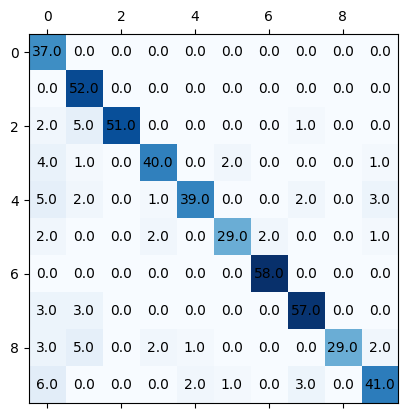

In [10]:
# Run evaluate of Numbers and shows the confusion matrix
numbers = Numbers()
numbers.report()
numbers.evaluate(KNNClassifier)

*Wow, I can't believe we just created a KNN Classifier for multiple classes - but can't we make it better?*

Yes, we saw above that our classifier didn't work perfectly. Let's explore try to understand why.


2.3 [10 points] Determine which classes are most often confused (from our confusion matrix above),
 inspect some examples of these digits (using the `view_digit` function in our Numbers class),
 and write a brief (4 - 5 sentences) description of why you think these particular numbers may be misclassified. (Avg __9.1__)

<Figure size 640x480 with 0 Axes>

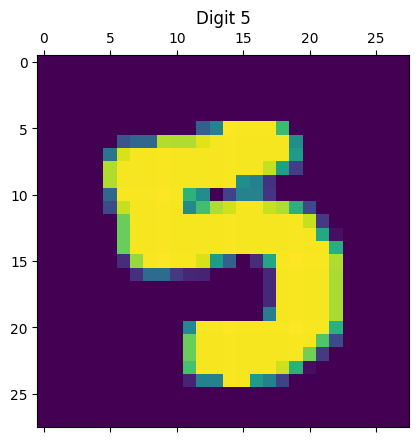

<Figure size 640x480 with 0 Axes>

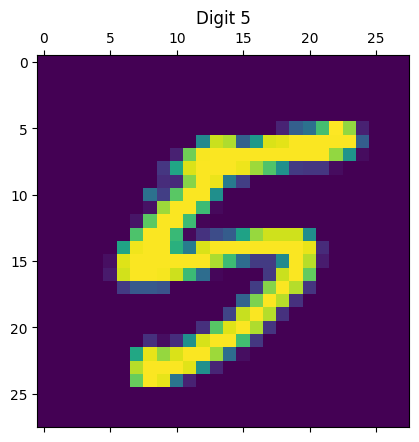

<Figure size 640x480 with 0 Axes>

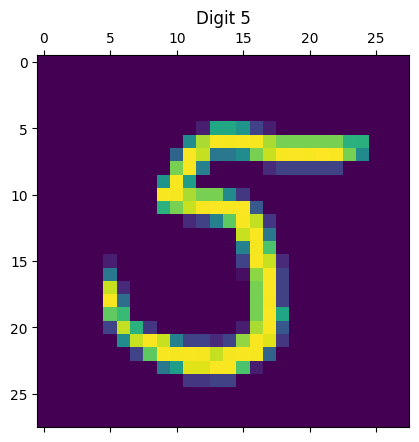

<Figure size 640x480 with 0 Axes>

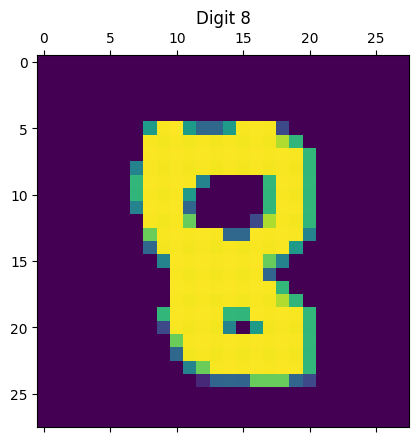

<Figure size 640x480 with 0 Axes>

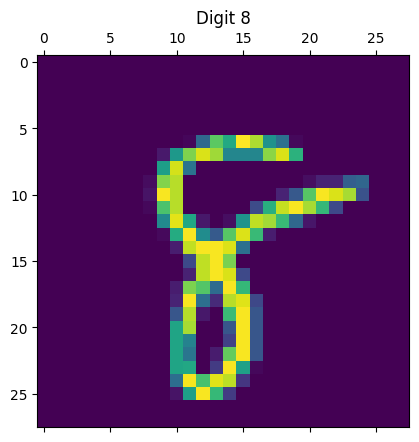

<Figure size 640x480 with 0 Axes>

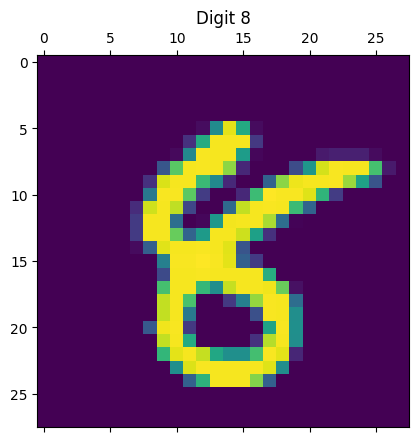

In [43]:
# Workspace 2.3.a
#TODO: Print out problem class images
#BEGIN 
# code here
q = 5 # digit to analyze
n = 3 # number of samples to display
for i, l in enumerate(numbers.data.y_test):
    if n == 0:
        break
    if l == q:
        numbers.view_digit(i, 'test')
        n -= 1

q = 8 # digit to analyze
n = 3 # number of samples to display
for i, l in enumerate(numbers.data.y_test):
    if n == 0:
        break
    if l == q:
        numbers.view_digit(i, 'test')
        n -= 1
#END

**Workspace 2.3.b**

TODO: Write description of mis-classification

__Answer :__ The KNN classifier measures the distance between the points of a query image and the training images, which indirectly means that it measures the _overlap_ between the query image and the training images. The digits most often misclassified are `5` and `8`, and we can analyze from the samples that there is quite high overlap between these and numbers like `0` and `4` respectively, which causes the misclassification. Other examples of the same are `9` being misclassified as `7` and `7` being misclassified as `1`.

Another reason for misclassification is how there is high variation in how some digits are written, as shown in the images above.

### Problem 3 : Improving KNN on MNIST using WeightedKNN (25 pts)
Complete the `WeightedKNNClassifier` class to perform the weighted KNN classification.
The Weighted KNN classifier assigns weights to the nearest-neighbor training examples proportional to
 the inverse-distance from the training example to the query point.

Classification is performed by summing the weights associated with each class and predicting the class with the highest weighted-majority vote.
 Mathematically, we might describe the weighted-vote for a class $c$ as

\begin{align}
\textrm{Weighted-Vote}(c)(x) = \sum_{i \in {\cal N}_K(x)} I(y_i \in c) \times \frac{1}{\|{\bf x}_i - {\bf x}\|}
\end{align}

where ${\cal N}_K(x)$ is the set of the nearest $k$ neighbors to $x$.

3.1 [10 points] Complete `weighted_vote`: it's certainly possible that a query point could be distance $0$ away from some training example.
 If this happens your implementation should handle it and return the appropriate class label.(Avg __7.8__)

3.2 [5 points] Complete `predict`. (Avg __4.9__)


In [22]:
class WeightedKNNClassifier(KNNClassifier):
    def weighted_vote(self, indices_nearest_k, distances_nearest_k):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param indices_nearest_k: The indices of the K nearest neighbors in self.X_train
        :param distances_nearest_k: Corresponding distances from query point to K nearest neighbors.
        """

        # Workspace 3.1
        #BEGIN 
        labels = np.empty((indices_nearest_k.shape[0]))  #REPLACE
        for i, (indices, distances) in enumerate(zip(indices_nearest_k, distances_nearest_k)):
            inv_distances = [0]*len(distances)
            for j, d in enumerate(distances):
                if d!=0:
                    inv_distances[j] = 1/d
                else:
                    inv_distances = [0]*len(distances)
                    inv_distances[j] = 1
                    break

            inv_dist_sum = sum(inv_distances)
            vote_weights = []
            for invd in inv_distances:
                vote_weights.append(invd/inv_dist_sum)

            og_labels = [self._y[j] for j in indices]
            vote_sums = {}
            for l, w in zip(og_labels, vote_weights):
                if l not in vote_sums:
                    vote_sums[l] = 0
                vote_sums[l] += w
            
            labels[i] = sorted(vote_sums.items(), key=lambda x: -x[1])[0][0]
        # code here
        #END

        return labels

    def predict(self, X):
        """
        Given an np.array of query points, return y_hat, an np.array of predictions
        :param X: an (m x p) dimension np.array of points to predict labels for
        """

        # Workspace 3.2
        ##BEGIN 
        distances_nearest_k, indices_nearest_k = self._ball_tree.query(X, k=self._k)                    
        labels = self.weighted_vote(indices_nearest_k, distances_nearest_k)
        #END
        return labels

In [23]:
# Test cell, uncomment to run the tests
tests.testWeightedKNN(WeightedKNNClassifier)

Question 3.1: [PASS]
Question 3.2: [PASS]


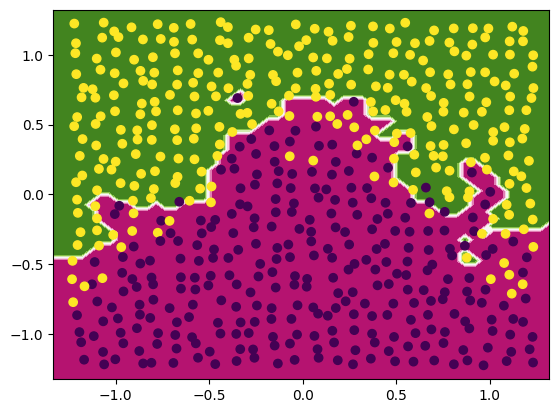

In [24]:
# Example on how to use the show_decision_surface
knn = WeightedKNNClassifier(3).fit(binary_data.X_train, binary_data.y_train)
tests.show_decision_surface(knn, binary_data.X, binary_data.y)

3.3 [5 points] Evaluate `WeightedKNNClassifier` on the binary data, similar to 1.5 digits data using `Numbers` class and compare it to `KNNClassifier` (Avg __4.6__)

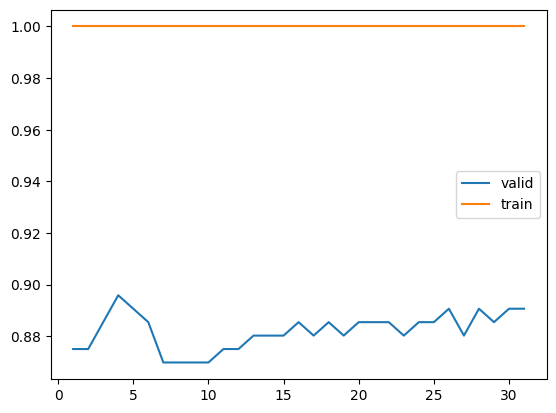

0.8958333333333334


In [25]:
# Workspace 3.3.a
#TODO: Try different Ks
ks = list(range(1, 32))
accuracies_train = []
accuracies_valid = []
for k in ks:
    #BEGIN 
    knn = WeightedKNNClassifier(k).fit(binary_data.X_train, binary_data.y_train)
    accuracies_train.append(knn.accuracy(binary_data.X_train, binary_data.y_train))
    accuracies_valid.append(knn.accuracy(binary_data.X_valid, binary_data.y_valid))
    #END
plt.plot(ks, accuracies_valid, label="valid")
plt.plot(ks, accuracies_train, label="train")
plt.legend()
plt.show()
print(np.max(accuracies_valid))

### # Workspace 3.3.b
__Write up__: Which classifier does better on the binary data

__Answer:__ 
```python
# find best validation k for WeightedKNNClassifier
print(f'Train Acc = {max(accuracies_train)}, k = {accuracies_train.index(max(accuracies_train))+1}') # output: Train Acc = 1.0, k = 1
print(f'Valid Acc = {max(accuracies_valid)}, k = {accuracies_valid.index(max(accuracies_valid))+1}') # output: Valid Acc = 0.8958333333333334, k = 4

# print the accuracy and confusion matrix on the test set using best k 
knn = WeightedKNNClassifier(4).fit(binary_data.X_train, binary_data.y_train)
print('Test Acc =', knn.accuracy(binary_data.X_test, binary_data.y_test))                            # output: Test Acc = 0.875
print('Test Confusion Matrix =\n', knn.confusion_matrix(binary_data.X_test, binary_data.y_test))     # output: Test Confusion Matrix =
                                                                                                     #              [[80.  3.]
                                                                                                     #              [21. 88.]]
```

The unweighted `KNNClassifier` performs better on the test set with an accuracy of `89.0625%` (refer to question 1.6), as compared to the `WeightedKNNClassifier`'s accuracy of `87.5%`, on the binary data.



3.4 [5 points] Compare `WeightedKNNClassifier` to `KNNClassifier` on the digits' data using `Numbers` class.

Majority Vote KNN Classifier:
best k: 3
Accuracy on test set: 0.866


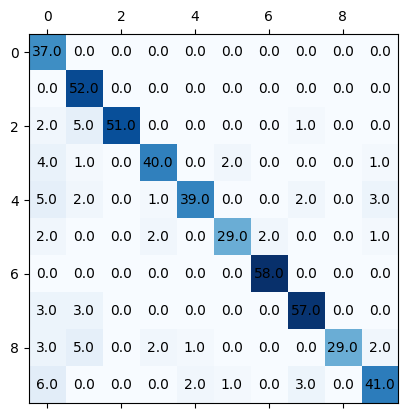


Weighted Vote KNN Classifier:
best k: 4
Accuracy on test set: 0.894


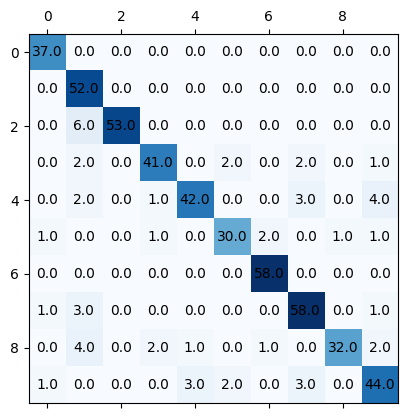

In [26]:
#Workspace 3.4.a
#BEGIN 
print("Majority Vote KNN Classifier:")
numbers.evaluate(KNNClassifier)
print("\nWeighted Vote KNN Classifier:")
numbers.evaluate(WeightedKNNClassifier)
#END


#### 3.4.b write-up

__Answer:__ The `Weighted Vote KNN Classifier` (89.4% accuracy) outperforms the `Majority Vote KNN Classifier` (86.6% accuracy).

#### Bonus
3.5 [2 points] Is `WeightedKNNClassifier` a consistent classifier? why? (Avg __1.1__)

#### 3.5 write-up

__Answer:__ Yes, the weighted KNN Classifier is consistent, as every time a query datapoint has already been seen during training, it's nearest point from the training data is itself (i.e. at distance zero). Thus weighting its neighbours inversely to their distance to the query would result in the query datapoint getting all of the weight and assign it the label that was seen in the training samples. This makes gives the weighted KNN perfect recall for all training samples, and makes it consistent.

### Problem 4 - Naive Bayes [25 points]
***
Consider the problem of predicting whether a person has a college degree based on age, salary, and Colorado residency.
The dataset looks like the following.

|Age|Salary|Colorado Resident| Has Siblings | College degree|
|:------:|:-----------:| :----------:| :----------:|--:|
| 37 | 44,000 | Yes | No  | Yes|
| 61 | 52,000 | Yes | No  | No |
| 23 | 44,000 | No  | No  | Yes|
| 39 | 38,000 | No  | Yes | Yes|
| 48 | 49,000 | No  | No  | Yes|
| 57 | 92,000 | No  | Yes | No |
| 38 | 41,000 | No  | Yes | Yes|
| 27 | 35,000 | Yes | No  | No |
| 23 | 26,000 | Yes | No  | No |
| 38 | 45,000 | No  | No  | No |
| 32 | 50,000 | No  | No  | Yes|
| 25 | 52,000 | Yes | No  | Yes|


In [27]:
features = np.array([
    [37, 44000, 1, 0],
    [61, 52000, 1, 0],
    [23, 44000, 0, 0],
    [39, 38000, 0, 1],
    [48, 49000, 0, 0],
    [57, 92000, 0, 1],
    [38, 41000, 0, 1],
    [27, 35000, 1, 0],
    [23, 26000, 1, 0],
    [38, 45000, 0, 0],
    [32, 50000, 0, 0],
    [25, 52000, 1, 0]
])
labels = np.array([1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1])

4.1 [3 points] Complete `threshold_features` to convert age and salary features to binary ones using the threshold arguments. (Avg __2.9__)

In [28]:
def threshold_features(features, age_threshold, salary_threshold):
    """
    Transform afe and salary to binary
    :param features: data array of shape (m, n_features) where features[:,0] for age, features[:,1} for salary
    :param age_threshold: used to "binarize" the data, 1 if age > age_threshold and 0 otherwise
    :param salary_threshold: used to "binarize" the data, 1 if salary > salary_threshold and 0 otherwise
    :return: binary features matrix
    """
    binary_features = features * 1  #This row just creates a "hard copy" of the X array so we can manipulate it as needed

    # Workspace 4.1
    #BEGIN 
    # code here
    binary_features[:, 0] = features[:, 0] > age_threshold
    binary_features[:, 1] = features[:, 1] > salary_threshold
    #END

    return binary_features

In [29]:
# Test cell, uncomment to run the tests
tests.test_threshold(threshold_features)

Question 4.1: [PASS]


4.2 [2 points] If we were to use only one binary feature (age >40, salary > 40000, colorado resident, has siblings),
then what's the highest accuracy we could achieve? Which feature should we use?

**Workspace 4.2**

__Answer:__ We can use any of the first three features (_Age_, _Salary_ and _Colorado Resident_), as they all give an accuracy of 66.67%, although the first and the third features are both inversely related to the labels. The last feature (_Has Siblings_) gives an accuracy of 50%.

## How to implement NaiveBayes
As seen during the class, given a row $(x_1, x_2, x_3)$, the naive Bayes classifier should assign the label $y$ that
maximizes:

\begin{align}
\log [p(y) \prod_i p(x_i | y)] = \log p(y) + \sum_{i} \log p(x_i | y)
\end{align}

$p(y)$ and $p(x_i | y)$ are computed using the training set (during `fit` call).

For this, we need two attributes to store
$\log p(y)$ and $\log p(x_i | y)$ for different features $i$.

Let's assume we're working with binary classes $\{0, 1\}$ and all features have discrete supports.
Then we will store `classes_log_probability` as an array of shape `(2,)` that contains:
\begin{bmatrix}
\log p(y=0),\log p(y=1)
\end{bmatrix}.

If feature $i$ has $2$ possible values $\{0, 1\}$, then $\log p(x_i | y)$ would be stored as a $ 2 \times 2$ matrix:
\begin{align}
A_i = 
    \begin{bmatrix}
    \log p(x_i=0 | y=0) & \log p(x_i=1| y=0)\\
    \log p(x_i=0 | y=1) & \log p(x_i=1 | y=1)
    \end{bmatrix}
\end{align}

`features_log_likelihood` should then store such matrix for each feature.

We have defined $p(x_i | y)$ as :
\begin{align}
p(x_i | y) = \frac{N_{y,x_i}}{N_y}
\end{align}
where $N_{y,i}$ is the number of rows where $y$ and $x_i$ occur together, and $N_y = \sum_i N_{y,x_i}$.

4.3 [2 points] Complete the method `compute_classes` and store the log prior in `classes_log_probability` (Avg __2__)

4.4 [5 points] Complete the method `compute_features` by storing the matrices $A_i$ in `self.features_log_likelihood` (Avg __4.3__)

4.5 [5 points] Complete the method `join_log_likelihood` that computes the likelihood quantities
 $[\sum_{i} \log p(x_i | y=0), \sum_{i} \log p(x_i | y=1)]$ for each observation

4.6 [3 points] Complete the `predict` method

In [40]:
class NaiveBayes(object):
    """
    NaiveBayes classifier for binary features and binary labels
    """
    def __init__(self, alpha=0.0):
        self.alpha = alpha
        self.classes_counts = None
        self.classes_log_probability = np.empty((2,))
        self.features_log_likelihood = []  # list of arrays where element i store log p(X[:,i], y)

    def compute_classes(self, y):
        """
        Computes the log prior of binary classes and stores the result in self.classes_log_probability
        :param y: binary labels array, shape (m,)
        """
        # Workspace 4.3
        #BEGIN 
        # code here
        c = {}
        for l in y:
            if l not in c:
                c[l] = 0
            c[l] += 1
        self.classes_counts = len(c)
        for label in c:
            self.classes_log_probability[label] = np.log(c[label]/len(y))
        #END

    def compute_features(self, X, y):
        """
        Computes the log likelihood matrices for different features and stores them in self.features_log_likelihood
        :param X: data matrix with binary features, shape (n_samples, n_features)
        :param y: binary labels array, shape (n_samples,)
        """
        # Workspace 4.4
        #BEGIN 
        # code here
        self.features_counts = X.shape[1]
        
        c = {}
        for l in y:
            if l not in c:
                c[l] = 0
            c[l] += 1

        self.features_log_likelihood = np.zeros((self.features_counts, self.classes_counts, 2))
        for s, l in zip(X, y):
            for f in range(self.features_counts):
                v = s[f]
                self.features_log_likelihood[f, l, v] += 1
        self.features_log_likelihood += self.alpha
        for l in c:
            self.features_log_likelihood[:, l, :] /= (c[l] + self.alpha*self.features_counts)
        self.features_log_likelihood = np.log(self.features_log_likelihood)
        #END

    def fit(self, X, y):
        """
        :param X: binary np.array of shape (n_samples, n_features) [values 0 or 1]
        :param y: corresponding binary labels of shape (n_samples,) [values 0 or 1]
        :return: Classifier
        """
        self.compute_classes(y)
        self.compute_features(X, y)
        return self

    def joint_log_likelihood(self, X):
        """
        Computes the joint log likelihood
        :param X: binary np.array of shape (n_samples, n_features) [values 0 or 1]
        :return: joint log likelihood array jll of shape (n_samples, 2), where jll[i] = [log p(X[i]|y=0),log p(X[i]|y=1)]
        """
        # Workspace 4.5
        joint_log_likelihood = np.zeros((X.shape[0], 2))
        #BEGIN 
        # code here
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                s = 0
                f = X[i][j]
                for y in range(2):
                    joint_log_likelihood[i][y] += self.features_log_likelihood[j, y, f]
        #END
        return joint_log_likelihood

    def predict(self, X):
        """
        :param X:
        :return:
        """
        # Workspace 4.6
        # TODO: Find the corresponding labels using Naive bayes logic
        #BEGIN 
        # code here
        y_hat = np.zeros((X.shape[0],))
        jp = self.joint_log_likelihood(X)
        for i in range(X.shape[0]):
            y_hat[i] = np.argmax([self.classes_log_probability[0]+jp[i][0], self.classes_log_probability[1]+jp[i][1]])
        #END
        return y_hat

    def accuracy(self, y, y_hat):
        correct = 0
        for i in range(len(y)):
            if y[i] == y_hat[i]:
                correct += 1
        print(f'Accuracy: {correct/len(y)}')

In [41]:
# Test cell, uncomment to run the tests
tests.test_NB(NaiveBayes)

Question 4.3: [PASS]
Question 4.4: [PASS]
Question 4.5: [PASS]
Question 4.6: [PASS]


4.7 [5 points] Using age 40 and salary 40,000 as thresholds, transform the features and evaluate (accuracy) the NaiveBayes classifier
on the training data. Does it outperform our baseline (of using one feature)? (Avg __4.5__)

In [42]:
naive_bayes = NaiveBayes()
#DONE: Transform features to binary features, fit the classifier, report the accuracy
#BEGIN 
# code here
binarized_features = threshold_features(features, 40, 40000)
naive_bayes.fit(binarized_features, labels)
preds = naive_bayes.predict(binarized_features)
naive_bayes.accuracy(labels, preds)
#END

Accuracy: 0.8333333333333334


**Bonus**

4.8 [2 points] Use the attribute `alpha` of the NaiveBayes to convert it to smoothed NaiveBayes presented during the class.
`alpha`defaults to 0, so editing the class should not affect NaiveBayes tests (Avg __1.8__)

__Answer:__ Smoothing has been added to the Naive Bayes classifier in the `compute_features` method, and has been demonstrated below.

```python
#Transform features to binary features, fit the classifier, report the accuracy
binarized_features = threshold_features(features, 40, 40000)

# making one feature value unseen by making all of them the same kind and setting alpha to smooth the unseen value
# (leaving alpha as 0 will cause a divide by zero error since no smoothing is taking place)
binarized_features[:, 0] = 0
naive_bayes = NaiveBayes(alpha=.5)

naive_bayes.fit(binarized_features, labels)
preds = naive_bayes.predict(binarized_features)
naive_bayes.accuracy(labels, preds)

# output: Accuracy: 0.75
```